Имеется простейшая n-канальная СМО с m местами в очереди; нтенсивность потока заявок lambda, потока обслуживания mu. Время пребывания заявки в очереди ограничено некоторым случайным сроком T, распределенным по показательному закону с параметром v. Если по истечению времени T заявка не была передана на обслуживание, она покидает СМО необслуженной.

Задание

Построить имитационную модель СМО. Сравнить характеристики СМО, полученные в результате моделирования, с теоретическими характеристиками (финальные вероятности состояний, абсолютная пропускная способность, вероятность отказа, средние число заявок в СМО, среднее число заявок в очереди, среднее время пребывания заявки в СМО, среднее время пребывания заявки в очереди, среднее число занятых каналов).

Продемонстрировать работоспособность модели с помощью графиков и построить графики, показывающие установку стационарного режима СМО. Исследовать СМО при различных параметрах n, m, lambda, mu,

http://stratum.ac.ru/education/textbooks/modelir/lection30.html

In [1]:
import bisect
import json
import math
import matplotlib.pyplot as plt 
import random
from enum import Enum, auto
from queue import Queue


class EventType(Enum):
    INCOMING_REQ = auto()
    REQ_PROCESSED = auto()
    QUEUE_LEAVE = auto()
    DRAW_PLOTS = auto()
    
    
class Event:
    
    def __init__(self, type, info=None):
        self.type = type
        self.info = info or dict()
    
    def __str__(self):
        return f"({self.type}, {self.info})"

In [30]:
class Model:

    def finalize_stats(self, T: float) -> dict:
        self.stats['rejection_probability'] = self.stats['skipped_requests'] / self.stats['overall_requests']     
        self.stats['propusknaya_sposobnostb'] = self.stats['processed_requests'] / T
        
        self.stats['mean_requests_in_smo'] = sum(num*t for num, t in enumerate(self.stats['states'])) / T
        self.stats['mean_requests_in_queue'] = sum((num-self.n)*t for num, t in enumerate(self.stats['states']) if num > self.n) / T
        self.stats['mean_busy_channels'] = (sum(num*t for num, t in enumerate(self.stats['states']) if num < self.n)
                                            + sum(t for num, t in enumerate(self.stats['states']) if num >= self.n)*self.n) / T  
        
        self.stats['mean_time_in_smo'] = (self.stats['time_in_process'] + self.stats['time_in_queue']) / self.stats['overall_requests']
        # финальные вероятности состояний
        self.stats['states'] = [item / T for item in self.stats['states']]

        return self.stats
    
    def reset(self):
        self.queue = Queue()
        
        # состояние СМО. может быть от 0(пустые каналы и очередь) до n+m
        self.state = 0 
        # sorted list of tuples (time_point, Event)
        self.horizon = []
        
        self.stats = {}
        # значения - кол-во времени, проведённое в заданном состоянии
        self.stats['states'] = [0.0] * (self.n+self.m+1)
        self.stats['processed_requests'] = self.stats['skipped_requests'] = self.stats['overall_requests'] = 0
        self.stats['time_in_process'] = 0
        self.stats['time_in_queue'] = 0
        
        
    def __init__(self, channels_len, queue_len, request_intensity,
                 mean_serve_time, mean_queue_wait_time, theory_states):
        self.n = channels_len
        self.m = queue_len

        # these will be passed as `lambd` to `generate_exponential_input`/`generate_puasson_stream`
        self.request_intensity = request_intensity
        self.serve_intensity = 1 / mean_serve_time
        self.queue_wait_intensity = 1 / mean_queue_wait_time
        
        self.theory_states = theory_states
        
        self.reset()
        
    @staticmethod
    def gen_exp_input(lambd: float):
        return -1 / lambd * math.log(random.random())
    
    def random_serve_time(self):
        return self.gen_exp_input(self.serve_intensity)
    
    def random_q_wait_time(self):
        return self.gen_exp_input(self.queue_wait_intensity)
    
    def draw_current_plots(self, time_point: float, T: float):
        fig, ax = plt.subplots(figsize=(14, 4))
        ax.set_title(f"Текущее время {time_point}/{T}")
        ax.set_ylim([0.0, 1.1])
        ax.plot(list(range(len(self.theory_states))),
                self.theory_states,
                label='Истинные вероятности')
        ax.plot(list(range(len(self.stats['states']))),
                [item / time_point for item in self.stats['states']],
                label='Текущие вероятности')
        fig.legend()
        fig.show()
        
    @staticmethod
    def gen_puasson_stream(lambd: float, T: int) -> list:
        """Args:
            lambda: интенсивность потока
            T: конец интервала (0, T], для которого нужно сгенерировать паусоновский поток
        """
        stream = []
        t = 0
        while 1:
            tau = Model.gen_exp_input(lambd)
            t += tau
            if t > T:
                return stream
            stream.append(t)
        return stream
    
    def add_event(self, time_point: float, event: Event):
        bisect.insort(self.horizon, (time_point, event))
    
    def add_request(self, current_time_point):
        done_time_point = current_time_point + self.random_serve_time()
        self.add_event(done_time_point, 
                       Event(EventType.REQ_PROCESSED,
                             {'start_processing': current_time_point}))
        
    def run(self, T: float, plots_step: float = None) -> dict:
        """Args:
                T: длительность имитации СМО
           Returns:
               dict: словарь со всеми статистиками
        """
        self.reset()
        requests_stream = self.gen_puasson_stream(self.request_intensity, T)
        self.horizon = [(r, Event(EventType.INCOMING_REQ)) for r in requests_stream]
        
        if plots_step is None:
            plots_step = T / 10
        t = plots_step
        while t <= T:
            bisect.insort(self.horizon, (t, Event(EventType.DRAW_PLOTS)))
            t += plots_step
            
        t = 0
        while t <= T and self.horizon:
            time_point, event = self.horizon.pop(0)
            self.stats['states'][self.state] += time_point - t
            if event.type == EventType.INCOMING_REQ:
                self.stats['overall_requests'] += 1
                if self.state < self.n + self.m:
                    # есть свободные каналы
                    if self.state < self.n:
                        self.add_request(time_point)
                    # есть свободные места в очереди
                    else:
                        leave_time_point = time_point + self.random_q_wait_time()
                        request_info = {'processed': False, 'left': False, 'when_entered': time_point}
                        leave_event = Event(EventType.QUEUE_LEAVE, request_info)
                        self.add_event(leave_time_point, leave_event)
                        self.queue.put(request_info)
                    self.state += 1        
                # нет мест в очереди
                else:
                    self.stats['skipped_requests'] += 1
            elif event.type == EventType.REQ_PROCESSED:
                self.stats['time_in_process'] += time_point - event.info['start_processing']
                while not self.queue.empty():
                    request_info = self.queue.get()
                    if request_info['left']:
                        continue
                    request_info['processed'] = True
                    self.stats['time_in_queue'] += time_point - request_info['when_entered']
                    self.add_request(time_point)
                    break
                self.stats['processed_requests'] += 1
                self.state -= 1 
            elif event.type == EventType.QUEUE_LEAVE:
                if not event.info['processed']:
                    event.info['left'] = True
                    self.stats['time_in_queue'] += time_point - event.info['when_entered']
                    self.stats['skipped_requests'] += 1
                    self.state -= 1
            else:  # event.type == EventType.DRAW_PLOTS:
                self.draw_current_plots(time_point, T)
            t = time_point
        self.stats['states'][self.state] += T - t
        
        return self.finalize_stats(T)

In [31]:
class TheoryStats:
        
    def __init__(self, channels_len,
                 queue_len,
                 request_intensity,
                 mean_serve_time,
                 mean_queue_wait_time):
        self.n = channels_len
        self.m = queue_len
        self.lambd = request_intensity
        self.mu = 1 / mean_serve_time
        self.v = 1 / mean_queue_wait_time
        self.alpha = request_intensity * mean_serve_time
        self.beta = 1 / mean_queue_wait_time * mean_serve_time
        
        self.calculate_final_probs()
    
    def calculate_final_probs(self):
        p0 = sum(self.alpha ** k / math.factorial(k) for k in range(self.n+1))
        p0_last_item = 0
        for i in range(1, self.m+1):
            tmp = self.alpha ** i
            product = 1
            for l in range(1, i+1):
                product *= self.n + l*self.beta
            p0_last_item += tmp / product
        p0 += self.alpha ** self.n / math.factorial(self.n) * p0_last_item
        p0  = 1 / p0

        states = [0.0] * (self.n+self.m+1)
        states[0] = p0
        for k in range(1, self.n+1):
            states[k] = self.alpha ** k / math.factorial(k) * p0
        for s in range(1, self.m+1): 
            product = 1
            for m in range(1, s+1):
                product *= self.n + m * self.beta
            states[self.n+s] = states[self.n] * self.alpha ** (s) / product
        self.states = states
    
    def generate(self) -> dict:
        stats = {}
        stats['states'] = self.states
        mean_busy_channels = (sum(num*p for num, p in enumerate(stats['states'][:self.n]))
                              + self.n * sum(stats['states'][self.n:]))
        stats['rejection_probability'] = 1 - self.mu / self.lambd * mean_busy_channels
        Q = 1 - stats['rejection_probability']
        stats['propusknaya_sposobnostb'] = self.lambd * Q
        
        stats['mean_requests_in_smo'] = sum(num*p for num, p in enumerate(stats['states']))
        sum_ = 0
        for i in range(1, self.m+1):
            tmp = i * self.alpha ** i
            product = 1
            for l in range(1, i+1):
                product *= self.n + l*self.beta
            sum_ += tmp / product
        stats['mean_requests_in_queue'] = stats['states'][self.n] * sum_
        stats['mean_busy_channels'] = mean_busy_channels
        stats['mean_time_in_smo'] = stats['mean_requests_in_smo'] / self.lambd
        return stats

theory stats
{
  "states": [
    0.0006550762568178746,
    0.004913071926134059,
    0.018424019723002723,
    0.046060049307506803,
    0.08636259245157527,
    0.12954388867736288,
    0.1619298608467036,
    0.17349627947861102,
    0.16265276201119783,
    0.1284100752719983,
    0.08755232404908973
  ],
  "rejection_probability": 0.14825526872312522,
  "propusknaya_sposobnostb": 4.258723656384374,
  "mean_requests_in_smo": 6.691600207946739,
  "mean_requests_in_queue": 0.30351472337017776,
  "mean_busy_channels": 6.388085484576561,
  "mean_time_in_smo": 1.338320041589348
}


/home/work/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


empirical stats
{
  "states": [
    0.001307326604749329,
    0.010927637598307793,
    0.023671354696332986,
    0.05399779611040757,
    0.08746803002815125,
    0.1273213437099633,
    0.16733665864293906,
    0.17089520549371537,
    0.16115875825328874,
    0.11423504109903646,
    0.08168084776310815
  ],
  "processed_requests": 4169,
  "skipped_requests": 685,
  "overall_requests": 4860,
  "time_in_process": 6260.363880249539,
  "time_in_queue": 277.59673662525273,
  "rejection_probability": 0.14094650205761317,
  "propusknaya_sposobnostb": 4.169,
  "mean_requests_in_smo": 6.5412228778469785,
  "mean_requests_in_queue": 0.27759673662525275,
  "mean_busy_channels": 6.263626141221726,
  "mean_time_in_smo": 1.3452593861882287
}


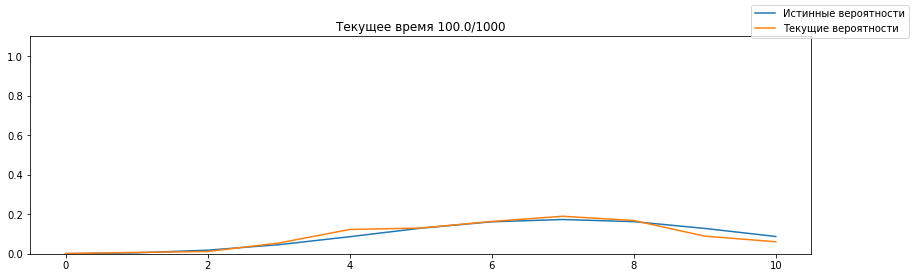

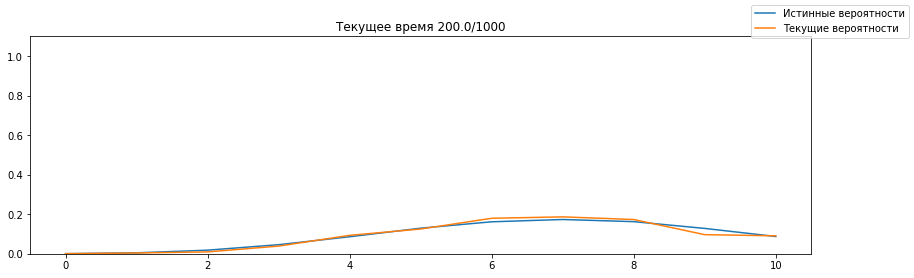

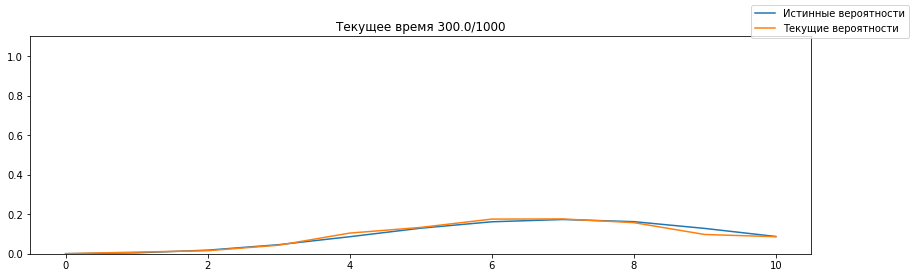

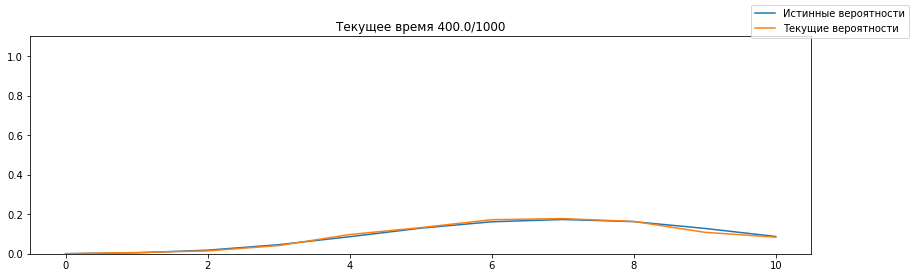

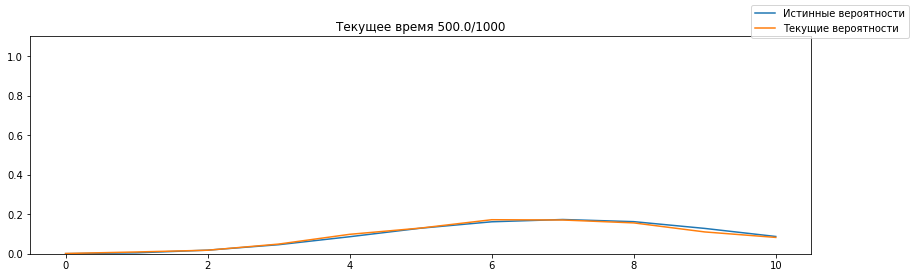

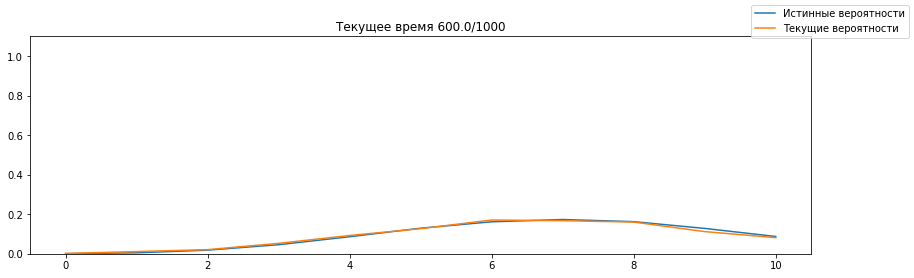

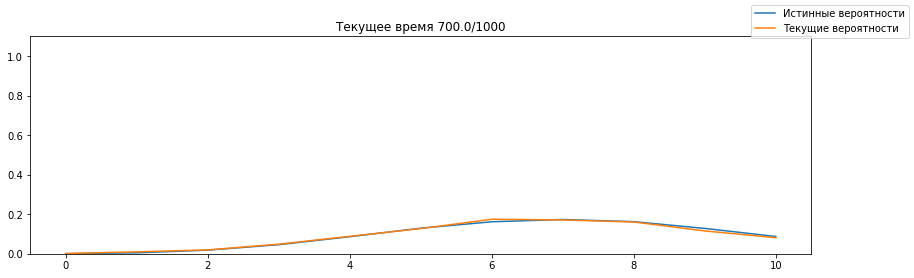

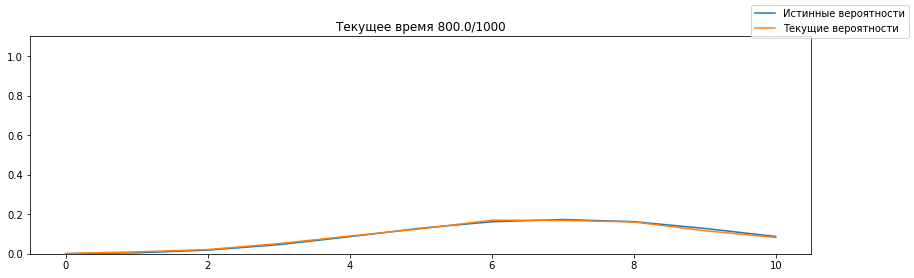

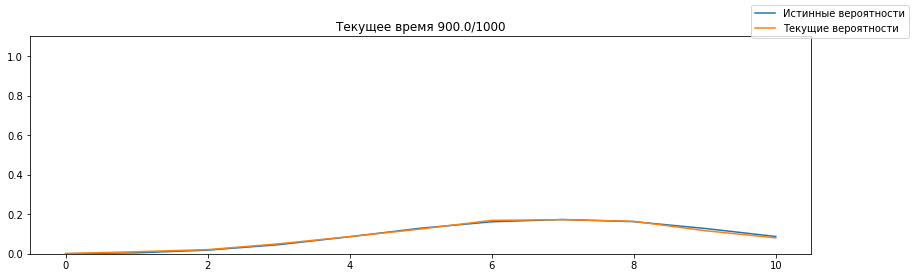

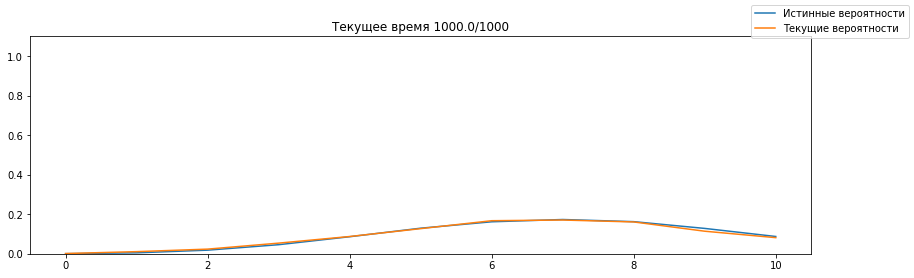

In [35]:
kwargs = {
    'channels_len': 8,
    'queue_len': 2,
    'request_intensity': 5,
    'mean_serve_time': 1.5,
    'mean_queue_wait_time': 1
}
theory_stats = TheoryStats(**kwargs).generate()
print(f"theory stats\n{json.dumps(theory_stats, indent=2)}")

kwargs['theory_states'] = theory_stats['states']
model = Model(**kwargs)
empirical_stats = model.run(1000)
print(f"empirical stats\n{json.dumps(empirical_stats, indent=2)}")